In [1]:
import gc # garbage collector
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm # progress bar
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.preprocessing import LabelEncoder

In [2]:
LISTE_MAJ = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
LISTE_MIN = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
LISTE_NBR = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

BATCH_SIZE = 256
EPOCHS = 10
ADD_NOM = "3_b" + str(BATCH_SIZE) + "_e" + str(EPOCHS)

In [3]:
# shape of the image : 50x50
# number of classes : 62 (26 letters majuscules, 26 letters minuscules, 10 chiffres)

# Dataset_Maj_test : 689_936
# Dataset_Maj_train : 2_405_456
# Dataset_Maj_validation : 692_000

# Get Data
---

- Récupération des données de la base de données
- formattage des données
- répartition des données

In [4]:
# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27017/Scibio")  # Remplacez par l'URL de votre serveur MongoDB
db = client["Scribio"]  # Nom de la base de données

In [5]:
def fetch_data(nom_collection: str, nbr: int):
    collection = db[nom_collection]  # Nom de la collection
    documents = collection.find()
    print(f"fetch {nom_collection} OK !!!")

    images = []
    labels = []
    types = []
    
    # Parcours et transformation des photos avec barre de progression 
    with tqdm(total=nbr, desc="Proccessing" , position=0, leave=True) as pbar:
        for doc in documents:
            images.append(np.array(doc["Tableau_Pixels"], dtype=np.float32))
            labels.append(doc["Label"])
            types.append(doc["Type"])
            pbar.update(1) # Mettre à jour la barre de progression
            
    # return np.array(images), np.array(labels, dtype=str)
    return pd.DataFrame({"Labels": labels, "Types": types, "Images": images})

### Récupérations des données de toutes les collections
---

In [6]:
df_maj_test = fetch_data("Dataset_Maj_test", 689_936)
df_maj_test = df_maj_test.sample(frac=1).reset_index(drop=True)
print(df_maj_test.shape)
df_maj_test.head()
# Temps : 41.2s

fetch Dataset_Maj_test OK !!!


Proccessing: 100%|██████████| 689936/689936 [00:40<00:00, 16844.04it/s]


(689936, 3)


,Labels,Types,Images
0,W,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,C,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,C,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,E,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,O,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [7]:
df_maj_train = fetch_data("Dataset_Maj_train", 2_405_456)
df_maj_train = df_maj_train.sample(frac=1).reset_index(drop=True)
print(df_maj_train.shape)
df_maj_train.head()
# Temps : 3m 1.7s

fetch Dataset_Maj_train OK !!!


Proccessing: 100%|██████████| 2405456/2405456 [03:00<00:00, 13323.76it/s]


(2405456, 3)


,Labels,Types,Images
0,F,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,D,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,N,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,I,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [8]:
df_maj_validation = fetch_data("Dataset_Maj_validation", 692_000)
df_maj_validation = df_maj_validation.sample(frac=1).reset_index(drop=True)
print(df_maj_validation.shape)
df_maj_validation.head()
# Temps : 1m 3.0s

fetch Dataset_Maj_validation OK !!!


Proccessing: 100%|██████████| 692000/692000 [01:02<00:00, 11035.39it/s]


(692000, 3)


,Labels,Types,Images
0,I,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,U,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,O,Maj,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,Y,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,N,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Données pour apprentissage du NN 'Get Maj'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Maj' qui permettra de classé les images selon la lettre majuscule qui y est representée.

In [ ]:
X_train_Maj = np.array(df_maj_train["Images"].tolist())
# Temps : 

In [ ]:
y_train_Maj = np.array(df_maj_train["Labels"].tolist())
# Temps : 

In [ ]:
X_test_Maj = np.array(df_maj_test["Images"].tolist())
# Temps : 

In [ ]:
y_test_Maj = np.array(df_maj_test["Labels"].tolist())
# Temps : 

In [ ]:
X_validation_Maj = np.array(df_maj_validation["Images"].tolist())
# Temps : 

In [ ]:
y_validation_Maj = np.array(df_maj_validation["Labels"].tolist())
# Temps : 

In [27]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Maj = LabelEncoder()

y_train_Maj_2 = label_encoder_Maj.fit_transform(y_train_Maj)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Maj_2 = label_encoder_Maj.transform(y_test_Maj)
y_validation_Maj_2 = label_encoder_Maj.transform(y_validation_Maj)

In [28]:
# Correspondance indices ↔ labels
correspondance_Maj = dict(enumerate(label_encoder_Maj.classes_))
print(correspondance_Maj)

# Liste des labels
labels_Maj = list(correspondance_Maj.values())
print(labels_Maj)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [29]:
# Afficher quelques informations
print(f"Taille de X_train_Maj: {X_train_Maj.shape}, y_train_Maj: {y_train_Maj.shape}, y_train_Maj_2: {y_train_Maj_2.shape}")
print(f"Taille de X_test_Maj: {X_test_Maj.shape}, y_test_Maj: {y_test_Maj.shape}, y_test_Maj_2: {y_test_Maj_2.shape}")
print(f"Taille de X_validation_Maj: {X_validation_Maj.shape}, y_validation_Maj: {y_validation_Maj.shape}, y_validation_Maj_2: {y_validation_Maj_2.shape}")

Taille de X_train_Maj: (2405456, 625), y_train_Maj: (2405456,), y_train_Maj_2: (2405456,)
Taille de X_test_Maj: (689936, 625), y_test_Maj: (689936,), y_test_Maj_2: (689936,)
Taille de X_validation_Maj: (692000, 625), y_validation_Maj: (692000,), y_validation_Maj_2: (692000,)


##### Suppression
---

Suppression des données pour l'apprentissage de 'Get Maj' plus utilisées

In [30]:
del df_maj_test, df_maj_train, df_maj_validation
gc.collect()  # Force la collecte des objets non utilisés

0

# Get Maj (NN)
---

Modèle ...

In [47]:
model_get_maj = keras.Sequential([
    keras.layers.Input((625,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(26, activation='softmax') # output layer : 26 neurones (A-Z)
])

model_get_maj.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_get_maj.fit(
    X_train_Maj, 
    y_train_Maj_2, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(
        X_validation_Maj, 
        y_validation_Maj_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.9508
# loss : 0.1701
# Temps : 5m 17.7s

# Batch 64
# accuracy : 0.9522
# loss : 0.1632
# Temps : 2m 18.6s

# Batch 128
# accuracy : 0.9558
# loss : 0.1531
# Temps : 1m 19.8s

# Batch 256
# accuracy : 0.9527
# loss : 0.1621
# Temps : 51.7s

In [48]:
test_loss_maj, test_acc_maj = model_get_maj.evaluate(X_test_Maj, y_test_Maj_2)
print(f"Test accuracy : {test_acc_maj}") # Test accuracy : 
print(f"Test loss : {test_loss_maj}") # Test loss : 
# Temps : 1.9s

1348/1348 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9356 - loss: 0.2853
Test accuracy : 0.9352519512176514
Test loss : 0.2858487069606781


In [49]:
# Sauvegarder le modèle
model_get_maj.save("../models/Get_Maj_v" + ADD_NOM + ".keras")  # Format HDF5 (.h5)

In [50]:
y_predicted_Maj = model_get_maj.predict(X_test_Maj)
y_predicted_Maj[1]
# Temps 1.8s

1348/1348 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


array([9.9999934e-01, 7.7308720e-01, 3.5535383e-01, 9.9393952e-01,
       8.8625532e-01, 8.9389563e-01, 5.9978044e-01, 9.9412745e-01,
       2.0962171e-01, 3.3624984e-02, 4.3295968e-02, 4.3806973e-01,
       6.0872602e-01, 9.7811294e-01, 6.6230005e-01, 9.8547041e-01,
       3.8519187e-03, 1.8753965e-01, 2.7242338e-03, 3.3365086e-02,
       4.1397437e-04, 7.9703750e-04, 5.4788470e-01, 2.4486220e-02,
       3.7600882e-02, 1.6414608e-05], dtype=float32)

In [51]:
np.argmax(y_predicted_Maj[1])

0

In [52]:
# y_predicted_labels_Maj = [correspondance_Maj[np.argmax(i)] for i in y_predicted_Maj]
y_predicted_labels_Maj = [np.argmax(i) for i in y_predicted_Maj]
y_predicted_labels_Maj[:5]

[15, 0, 21, 8, 14]

Text(95.72222222222221, 0.5, 'Truth')

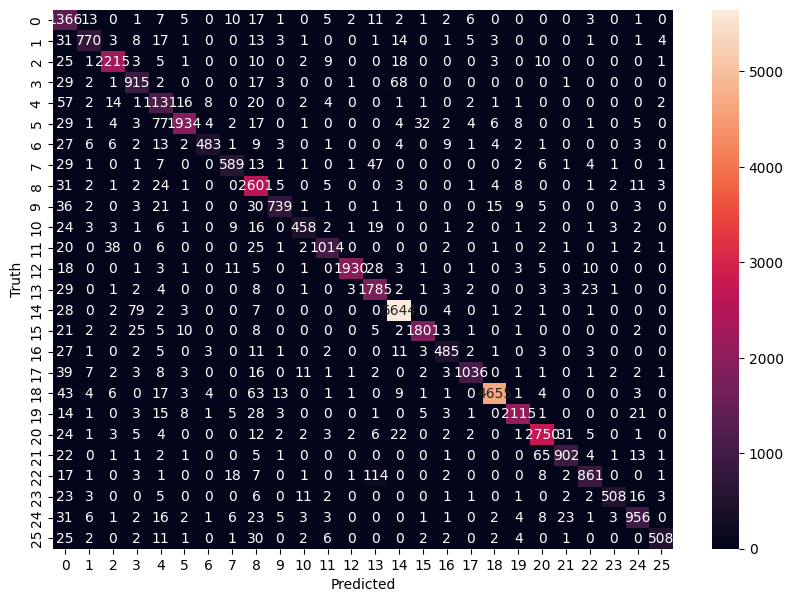

In [53]:
# Matrice de confusion
cm_Maj = tf.math.confusion_matrix(labels=y_test_Maj_2, predictions=y_predicted_labels_Maj)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Maj, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')